In [3]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Chage cwd
print(f'CWD: \n{os.getcwd()}')
os.chdir('../..')
print(f'CWD: \n{os.getcwd()}')

CWD: 
c:\Users\tyler\OneDrive\Documents\Python\MLB\backend\analysis
CWD: 
c:\Users\tyler\OneDrive\Documents\Python\MLB


In [5]:
# Load schedules
schedule = pd.DataFrame()
for season in range(2022-5, 2022):
    schedule = schedule.append(pd.read_csv(f'backend/data/schedules/{season}.csv'), ignore_index=True)

schedule['date'] = pd.to_datetime(schedule['date'])
schedule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10815 entries, 0 to 10814
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     10815 non-null  datetime64[ns]
 1   visitor  10815 non-null  object        
 2   home     10815 non-null  object        
 3   season   10815 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 338.1+ KB


In [6]:
# Load scores
scores = pd.read_csv('backend/data/scores/boxscore.csv')
scores['date'] = pd.to_datetime(scores['date'])

scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22148 entries, 0 to 22147
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  22148 non-null  int64         
 1   date        22148 non-null  datetime64[ns]
 2   visitor     22148 non-null  object        
 3   home        22148 non-null  object        
 4   team        22148 non-null  object        
 5   1           22148 non-null  int64         
 6   2           22148 non-null  int64         
 7   3           22148 non-null  int64         
 8   4           22148 non-null  int64         
 9   5           22148 non-null  object        
 10  6           22140 non-null  object        
 11  7           22124 non-null  object        
 12  8           21700 non-null  object        
 13  9           21646 non-null  object        
 14  R           22148 non-null  int64         
 15  H           22148 non-null  int64         
 16  E           22148 non-

In [7]:
# Load batting totals
batting_totals = pd.read_csv('backend/data/batting/totals.csv')
batting_totals['date'] = pd.to_datetime(batting_totals['date'])
batting_totals['wpa-'] = batting_totals['wpa-'].apply(lambda x: float(x.strip("%")))
batting_totals['cwpa'] = batting_totals['cwpa'].apply(lambda x: float(x.strip("%")))
batting_totals = batting_totals.fillna(0)
batting_totals = batting_totals[batting_totals['ab'] != 0]

batting_totals.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22148 entries, 0 to 22147
Data columns (total 47 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  22148 non-null  int64         
 1   date        22148 non-null  datetime64[ns]
 2   visitor     22148 non-null  object        
 3   home        22148 non-null  object        
 4   team        22148 non-null  object        
 5   ab          22148 non-null  int64         
 6   r           22148 non-null  int64         
 7   h           22148 non-null  int64         
 8   rbi         22148 non-null  int64         
 9   bb          22148 non-null  int64         
 10  so          22148 non-null  int64         
 11  pa          22148 non-null  int64         
 12  ba          22148 non-null  float64       
 13  obp         22148 non-null  float64       
 14  slg         22148 non-null  float64       
 15  ops         22148 non-null  float64       
 16  pit         22148 non-

In [33]:
def merge_schedule(df, schedule):
    df = pd.merge(
        schedule.drop(['season'], axis=1),
        df,
        left_on=['date', 'visitor', 'home'],
        right_on=['date', 'visitor', 'home'],
        how='left'
    )

    shifted_data = pd.DataFrame()

    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team', 'h_target'})):
                team_df[col] = team_df[col].shift(1)

            shifted_data = shifted_data.append(team_df, ignore_index=True)

    return shifted_data

In [8]:
# Function for feature engineering stats
def feature_engineer(df):
   df['ba'] = df['h'] / df['ab']
   df['obp'] = (df['h'] + df['bb'] + df['hbp']) / (df['ab'] + df['bb'] + df['hbp'] + df['sf'])
   df['1b'] = df['h'] - (df['2b'] + df['3b'] + df['hr'])
   df['slg'] = (df['1b'] + 2*df['2b'] + 3*df['3b'] + 4*df['hr']) / df['ab']
   df['ops'] = df['obp'] + df['slg']

   return df
   

In [25]:
# Function for sma
def sma(bin, df):

    sma_df = pd.DataFrame()
    
    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].rolling(bin, closed='left').mean()
            
            sma_df = sma_df.append(team_df, ignore_index=True)
    
    sma_df = pd.merge(
        sma_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    sma_df = feature_engineer(sma_df)

    return sma_df.sort_values(by=['date'])

In [36]:
# Function for cma
def cma(df, schedule):

    df = pd.merge(
        schedule.drop(['season'], axis=1),
        df,
        left_on=['date', 'visitor', 'home'],
        right_on=['date', 'visitor', 'home'],
        how='left'
    )

    cma_df = pd.DataFrame()

    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].expanding(1).mean()
                team_df[col] = team_df[col].shift(1)
            
            cma_df = cma_df.append(team_df, ignore_index=True)
    
    cma_df = pd.merge(
        cma_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    cma_df = feature_engineer(cma_df)

    return cma_df.sort_values(by=['date'])

In [31]:
# Function for ema
def ema(df, schedule):

    df = pd.merge(
        schedule.drop(['season'], axis=1),
        df,
        left_on=['date', 'visitor', 'home'],
        right_on=['date', 'visitor', 'home'],
        how='left'
    )

    ema_df = pd.DataFrame()

    for team in df['team'].unique():
        for season in df['date'].dt.year.unique():
            team_df = df[(df['team'] == team) & (df['date'].dt.year == season)].sort_values(by=['date']).copy()
            for col in list(set(df.columns).difference({'date', 'visitor', 'home', 'team'})):
                team_df[col] = team_df[col].ewm(alpha=2 / 3).mean()
                team_df[col] = team_df[col].shift(1)
            
            ema_df = ema_df.append(team_df, ignore_index=True)
    
    ema_df = pd.merge(
        ema_df, 
        df[['date', 'visitor', 'home', 'team', 'h']],
        left_on=['date', 'visitor', 'home', 'team'], 
        right_on=['date', 'visitor', 'home', 'team'],
        suffixes=('', '_target')
    )

    ema_df = feature_engineer(ema_df)

    ema_df = merge_schedule(ema_df, schedule)

    return ema_df.sort_values(by=['date'])

In [34]:
# Apply SMA (season, last 20 games, last 10 games, last 5 games, last 3 games, last game)
cols = list(set(batting_totals.columns).difference({'obp', 'slg', 'ops', 'wpa', 'ali', 'wpa+', 'wpa-', 'cwpa', 'acli', 're24'}))
df = batting_totals[cols]
ema_df = ema(df, schedule)
sma_df = sma(1, df)
cma_df = cma(df, schedule)

In [21]:
sma_df[(sma_df['date'].dt.year == 2021) & (sma_df['team'] == 'Boston Red Sox')][['date', 'visitor', 'home', 'h', 'h_target']].head()

,date,visitor,home,h,h_target
18987,2021-04-02,Baltimore Orioles,Boston Red Sox,NaN,2
18988,2021-04-03,Baltimore Orioles,Boston Red Sox,2.0,7
18989,2021-04-04,Baltimore Orioles,Boston Red Sox,7.0,6
18990,2021-04-05,Tampa Bay Rays,Boston Red Sox,6.0,16
18991,2021-04-06,Tampa Bay Rays,Boston Red Sox,16.0,10


In [35]:
cma_df[(cma_df['date'].dt.year == 2021) & (cma_df['team'] == 'Boston Red Sox')][['date', 'visitor', 'home', 'h', 'h_target']].head()

,date,visitor,home,h,h_target
5497,2021-04-02,Baltimore Orioles,Boston Red Sox,NaN,2.0
5498,2021-04-03,Baltimore Orioles,Boston Red Sox,2.00,7.0
5499,2021-04-04,Baltimore Orioles,Boston Red Sox,4.50,6.0
5500,2021-04-05,Tampa Bay Rays,Boston Red Sox,5.00,16.0
5501,2021-04-06,Tampa Bay Rays,Boston Red Sox,7.75,10.0


In [24]:
# Correlations
corr_df = pd.DataFrame()
dfs = {'cma': cma_df, '20 game': sma_df, 'ema': ema_df}
for df in dfs:
    for col in set(dfs[df]).difference({'date', 'visitor', 'home', 'team', 'h_target'}):
        corr_df = corr_df.append({'df': df, 'col': col, 'corr': dfs[df].iloc[:-1, :][col].corr(dfs[df].iloc[1:, :]['h_target'])}, ignore_index=True)

print(corr_df[corr_df['corr'].abs() >= .7].sort_values(by=['corr'], ascending=False))

     col      corr   df
95     h  0.916571  ema
87    ba  0.874929  ema
102  obp  0.761929  ema
106  ops  0.720331  ema
76     r  0.714136  ema
88   rbi  0.711541  ema
99    ab  0.674011  ema
93    1b  0.660266  ema
105   pa  0.654370  ema
96   slg  0.618456  ema


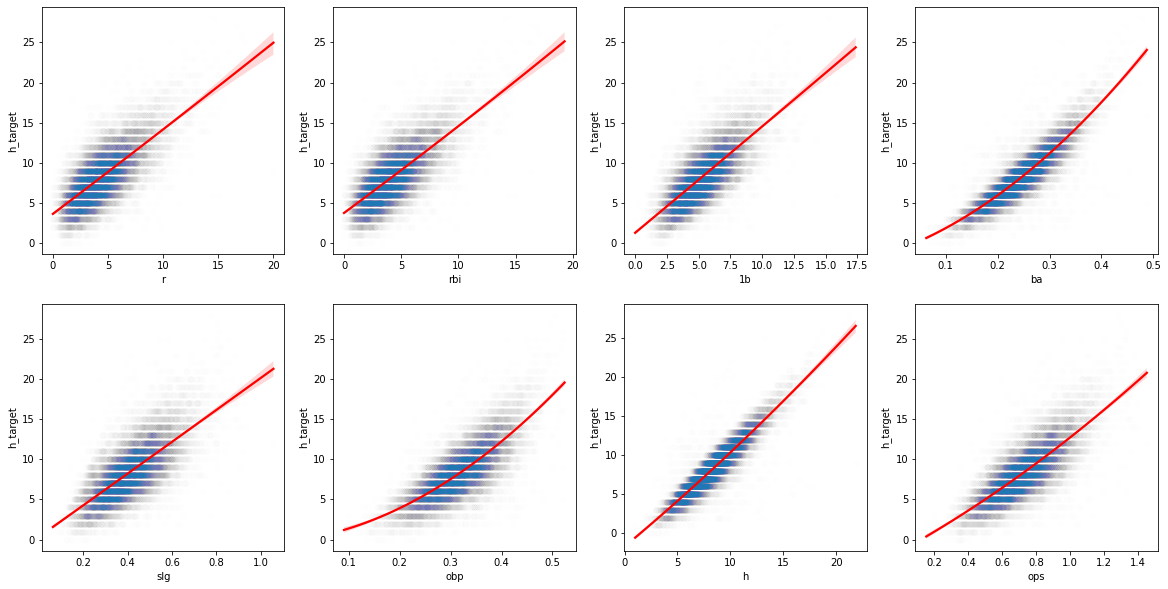

In [31]:
# Graph
cols = corr_df[corr_df['corr'].abs() >= .7]['col'].unique()
fig, ax = plt.subplots(2, 4, figsize=(20, 10))

for i in range(2):
    for j in range(4):
        stat = cols[i*4 + j]
        sns.regplot(
            data=ema_season, 
            x=stat,
            y='h_target',
            order=2,
            ax=ax[i, j], 
            scatter_kws={'alpha':0.004}, 
            line_kws={"color": "red"}
            )

plt.show()

In [96]:
# Load pitching totals
pitching_totals = pd.read_csv('backend/data/pitching/totals.csv')
pitching_totals['date'] = pd.to_datetime(pitching_totals['date'])
pitching_totals['cwpa'] = pitching_totals['cwpa'].apply(lambda x: float(x.strip('%')))

pitching_totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22148 entries, 0 to 17214
Data columns (total 30 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     22148 non-null  datetime64[ns]
 1   visitor  22148 non-null  object        
 2   home     22148 non-null  object        
 3   team     22148 non-null  object        
 4   ip       22148 non-null  float64       
 5   h        22148 non-null  int64         
 6   r        22148 non-null  int64         
 7   er       22148 non-null  int64         
 8   bb       22148 non-null  int64         
 9   so       22148 non-null  int64         
 10  hr       22148 non-null  int64         
 11  era      22148 non-null  float64       
 12  bf       22148 non-null  int64         
 13  pit      22148 non-null  int64         
 14  str      22148 non-null  int64         
 15  ctct     22148 non-null  int64         
 16  sts      22148 non-null  int64         
 17  stl      22148 non-null  int64 

In [33]:
# Function for feature engineering stats
def feature_engineer(df):
   df['era'] = 9 * df['er'] / df['ip']

   return df

In [34]:
# Apply SMA (season, last 20 games, last 10 games, last 5 games, last 3 games, last game)
cols = list(set(pitching_totals.columns).difference({'era', 'gsc', 'wpa', 'ali', 'cwpa', 'acli', 're24'}))
df = pitching_totals[cols]
cma_season = cma(df)
ema_season = ema(df)
sma_20, sma_10, sma_5, sma_3, sma_1 = sma(20, df), sma(10, df), sma(5, df), sma(3, df), sma(1, df)

In [35]:
# Correlations
corr_df = pd.DataFrame()
dfs = {'cma': cma_season, '20 game': sma_20, '10 game': sma_10, '5 game': sma_5, '3 game': sma_3, '1 game': sma_1, 'ema': ema_season}
for df in dfs:
    for col in set(dfs[df]).difference({'date', 'visitor', 'home', 'team', 'h_target'}):
        corr_df = corr_df.append({'df': df, 'col': col, 'corr': dfs[df].iloc[:-1, :][col].corr(dfs[df].iloc[1:, :]['h_target'])}, ignore_index=True)

print(corr_df[corr_df['corr'].abs() >= .7].sort_values(by=['corr'], ascending=False))

    col      corr   df
133   h  0.918070  ema
126   r  0.718272  ema
121  er  0.712397  ema


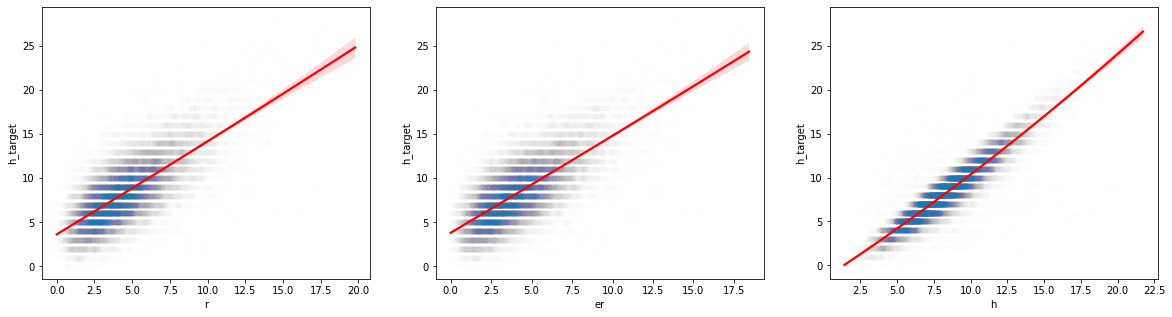

In [17]:
# Graph
cols = corr_df[corr_df['corr'].abs() >= .7]['col'].unique()
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for j in range(3):
    stat = cols[j]
    sns.regplot(
        data=ema_season, 
        x=stat,
        y='h_target',
        order=2,
        ax=ax[j], 
        scatter_kws={'alpha':0.004}, 
        line_kws={"color": "red"}
        )

plt.show()

In [19]:
# Load pitching details
pitching_details = pd.read_csv('backend/data/pitching/details.csv')
pitching_details['date'] = pd.to_datetime(pitching_details['date'])
pitching_details['cwpa'] = pitching_details['cwpa'].apply(lambda x: float(x.strip('%')))
pitching_details = pitching_details.replace([np.inf, -np.inf], np.nan)

pitching_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75149 entries, 0 to 75148
Data columns (total 31 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     75149 non-null  datetime64[ns]
 1   visitor  75149 non-null  object        
 2   home     75149 non-null  object        
 3   team     75149 non-null  object        
 4   player   75149 non-null  object        
 5   ip       75149 non-null  float64       
 6   h        75149 non-null  int64         
 7   r        75149 non-null  int64         
 8   er       75149 non-null  int64         
 9   bb       75149 non-null  int64         
 10  so       75149 non-null  int64         
 11  hr       75149 non-null  int64         
 12  era      75074 non-null  float64       
 13  bf       75149 non-null  int64         
 14  pit      75129 non-null  float64       
 15  str      75129 non-null  float64       
 16  ctct     75060 non-null  float64       
 17  sts      75129 non-null  float6